In [3]:
# Necessary installation for dimensionality Multicollinearity
! pip install varclushi

In [109]:
import sklearn
import tensorflow
import pickle
import matplotlib.pyplot as plt
import datetime 
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
from varclushi import VarClusHi
from google.cloud import aiplatform, bigquery, storage
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.losses import BinaryCrossentropy 
from tensorflow.keras.callbacks import ModelCheckpoint

## Get data from Big Query

In [5]:
client = bigquery.Client()
query_job = client.query(
"""
SELECT
    id
    ,symbol
    ,name
    ,date
    ,market_data.current_price as current_price
    ,market_data.market_cap as market_cap
    ,market_data.total_volume as total_volume
    ,public_interest_stats.alexa_rank as alexa_rank
    ,public_interest_stats.bing_matches as bing_matches
    ,developer_data.pull_request_contributors as pull_request_contributors
    ,developer_data.commit_count_4_weeks as commit_count_4_weeks
    ,developer_data.pull_requests_merged as pull_requests_merged
    ,developer_data.closed_issues as closed_issues
    ,developer_data.stars as stars
    ,developer_data.total_issues as total_issues
    ,developer_data.code_additions_deletions_4_weeks as code_additions_deletions_4_weeks
    ,developer_data.subscribers as subscribers
    ,developer_data.forks as forks
    ,image.small as small
    ,image.thumb as thumb
    ,community_data.reddit_accounts_active_48h as reddit_accounts_active_48h
    ,community_data.reddit_average_comments_48h as reddit_average_comments_48h
    ,community_data.reddit_subscribers as reddit_subscribers
    ,community_data.reddit_average_posts_48h as reddit_average_posts_48h
    ,community_data.twitter_followers as twitter_followers
    ,community_data.facebook_likes as facebook_likes
FROM `crispy-computing-machine.crispy_dwh.crypto_btc`
""")
df = query_job.result().to_dataframe()

### Exploratory Data Analysis

In [6]:
print(df.shape)

(1909, 26)


There are 1,909 rows and 26 columns. It is a medium size dataset with a medium number of rows and a medium number of columns.

In [7]:
!pip install colorama

In [8]:
from colorama import Fore, Back, Style # For text colors
y_= Fore.CYAN
m_= Fore.WHITE

In [9]:
print(f"{m_}Total records:{y_}{df.shape}\n")
print(f"{m_}Data types of data columns: \n{y_}{df.dtypes}")

Total records:(1909, 26)

Data types of data columns: 
id                                   object
symbol                               object
name                                 object
date                                 object
current_price                       float64
market_cap                          float64
total_volume                        float64
alexa_rank                            int64
bing_matches                         object
pull_request_contributors           float64
commit_count_4_weeks                float64
pull_requests_merged                float64
closed_issues                       float64
stars                               float64
total_issues                        float64
code_additions_deletions_4_weeks     object
subscribers                         float64
forks                               float64
small                                object
thumb                                object
reddit_accounts_active_48h          float64
reddit_average_commen

There are int64, object, and float64 dtypes in features of our dataset. Generally, object dtype is used for Categorical Variables. int64 and float64 dtypes are used for Numerical Variables.


### Variable Definition

**id**: name of crypto

**current_price**:price of the cryptocurrency

**market_cap**: is the total value of all the coins that have been mined. It's calculated by multiplying the number of coins in circulation by the current market price of a single coin.

**total_volume**: Total cryptocurrency trading volume in the last day

**alexa_rank**: Alexa rank is a measure of website popularity. It ranks millions of websites in order of popularity, with an Alexa Rank of 1 being the most popular. Alexa Rank reveals how a website is doing relative to all other sites, which makes it a great KPI for benchmarking and competitive analysis

**bing_matches**: Add provided by Microsoft. Stopped in 2018


**pull_request, pull_request_contributors,commit_count_4_weeks, pull_requests_merged, closed_issues, total_issues,code_additions_deletions_4_weeks, and forks**: Ussually are proposed changes to the code or documentation in the source code repository

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                1909 non-null   object 
 1   symbol                            1909 non-null   object 
 2   name                              1909 non-null   object 
 3   date                              1909 non-null   object 
 4   current_price                     1909 non-null   float64
 5   market_cap                        1908 non-null   float64
 6   total_volume                      1909 non-null   float64
 7   alexa_rank                        1909 non-null   int64  
 8   bing_matches                      0 non-null      object 
 9   pull_request_contributors         1788 non-null   float64
 10  commit_count_4_weeks              1763 non-null   float64
 11  pull_requests_merged              1788 non-null   float64
 12  closed

There are 18 features as *float64* dtype, 1 feature as *int64* dtype, 1 feature as *datetime*, and 6 features as *object* dtype.

The **bing_matches** and **facebook_likes** features has 0 non-null values out of 1,909.

The **pull_request_contributors**  and **pull_requests_merged** features has 1,788 non-null values out of 1,909.

The **commit_count_4_weeks** feature has 1,763 non-null values out of 1,909.

The **closed_issues**, **stars**, **total_issues**, **subscribers** and **forks** features has 1,769 non-null values out of 1,909.

### Basic information 

In [11]:
df.describe()

,current_price,market_cap,total_volume,alexa_rank,pull_request_contributors,commit_count_4_weeks,pull_requests_merged,closed_issues,stars,total_issues,subscribers,forks,reddit_accounts_active_48h,reddit_average_comments_48h,reddit_subscribers,reddit_average_posts_48h,twitter_followers
count,1909.000000,1.908000e+03,1.909000e+03,1909.000000,1788.000000,1763.000000,1788.000000,1769.000000,1769.000000,1769.000000,1769.000000,1769.000000,1897.000000,1909.000000,1.897000e+03,1909.000000,1.840000e+03
mean,16599.862578,3.057727e+11,2.058751e+10,9722.027763,584.077181,259.532048,6645.268456,3524.305257,37331.535896,4000.771057,3169.717920,21578.332956,6481.092742,487.742344,1.471329e+06,4.877114,7.075110e+05
std,17431.500617,3.304798e+11,2.019060e+10,3951.574425,117.698075,73.856308,1522.006368,1894.950440,13801.283869,2087.233168,796.126906,7098.101846,3870.246837,437.885956,1.064996e+06,2.090997,1.317022e+06
min,784.277500,1.262408e+10,2.028832e+07,2692.000000,378.000000,91.000000,4099.000000,0.000000,10874.000000,0.000000,1290.000000,7124.000000,393.000000,0.000000,1.984680e+05,0.000000,5.123600e+04
25%,5841.053771,1.006494e+11,2.953789e+09,6058.000000,482.000000,206.000000,5276.250000,2673.000000,30578.000000,3156.000000,3206.000000,18343.000000,3891.461538,210.957000,8.160220e+05,2.478000,6.826400e+04
50%,8878.428260,1.581698e+11,1.890459e+10,9893.000000,589.000000,256.000000,6558.000000,3605.000000,39406.000000,4159.000000,3507.000000,23707.000000,5228.833333,284.435000,1.115562e+06,4.652000,7.326450e+04
75%,18807.095403,3.469306e+11,3.142360e+10,12740.000000,691.000000,303.000000,7932.750000,5183.000000,45455.000000,5745.000000,3572.000000,26437.000000,9078.000000,675.208000,1.797090e+06,6.750000,3.491368e+05
max,67617.015545,1.278798e+12,1.788941e+11,18724.000000,773.000000,470.000000,9548.000000,6182.000000,62765.000000,6794.000000,3907.000000,31890.000000,26336.000000,3647.545000,4.026841e+06,9.500000,4.863826e+06


### For each numerical feature compute number of unique entries

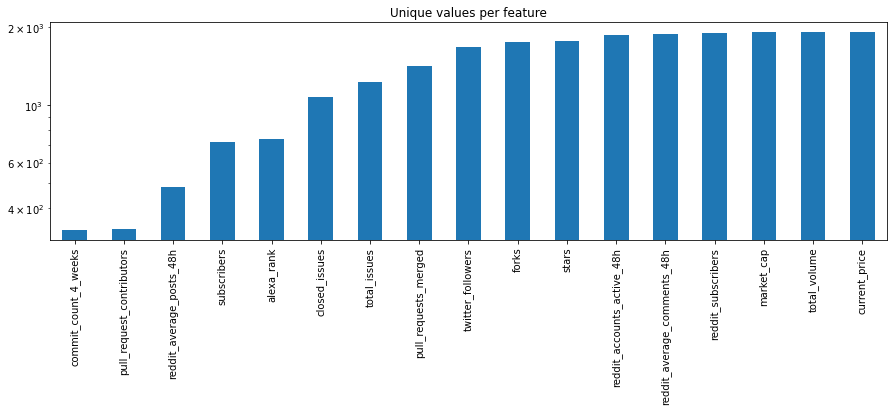

In [12]:
unique_values = df.select_dtypes(
  include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

The **current_price**, **market_cap** and **total_volume** features has the most unique values

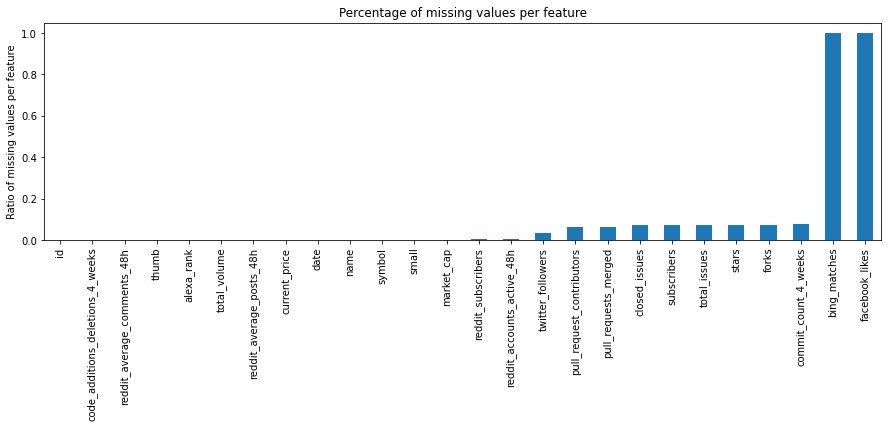

In [13]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

**bing_matches** and **facebook_likes** are made up of null values


### Summary of variables with null values


In [14]:
df.isnull().sum()

id                                     0
symbol                                 0
name                                   0
date                                   0
current_price                          0
market_cap                             1
total_volume                           0
alexa_rank                             0
bing_matches                        1909
pull_request_contributors            121
commit_count_4_weeks                 146
pull_requests_merged                 121
closed_issues                        140
stars                                140
total_issues                         140
code_additions_deletions_4_weeks       0
subscribers                          140
forks                                140
small                                  0
thumb                                  0
reddit_accounts_active_48h            12
reddit_average_comments_48h            0
reddit_subscribers                    12
reddit_average_posts_48h               0
twitter_follower

The **current_price**, **total_volume**, **alexa_rank**, **code_additions_deletions_4_weeks**, **smal**l and **thumb** features has cero null values


Looking for missing values in a heatmap

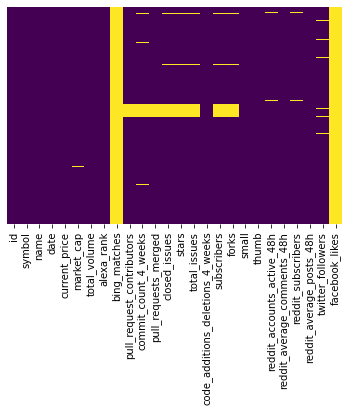

In [15]:
import seaborn as sns
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

Get rid of the **bing_marches** and the **facebook_likes** features


In [16]:
df.drop('bing_matches', axis=1, inplace=True)
df.drop('facebook_likes', axis=1, inplace=True)

Assign the average value to all NaN´s

In [17]:
df.loc[df.pull_request_contributors.isnull(), 'pull_request_contributors'] = df[~df.pull_request_contributors.isnull()].pull_request_contributors.mean()
df.loc[df.commit_count_4_weeks.isnull(), 'commit_count_4_weeks'] = df[~df.commit_count_4_weeks.isnull()].commit_count_4_weeks.mean()
df.loc[df.pull_requests_merged.isnull(), 'pull_requests_merged'] = df[~df.pull_requests_merged.isnull()].pull_requests_merged.mean()
df.loc[df.closed_issues.isnull(), 'closed_issues'] = df[~df.closed_issues.isnull()].closed_issues.mean()
df.loc[df.stars.isnull(), 'stars'] = df[~df.stars.isnull()].stars.mean()
df.loc[df.total_issues.isnull(), 'total_issues'] = df[~df.total_issues.isnull()].total_issues.mean()
df.loc[df.subscribers.isnull(), 'subscribers'] = df[~df.subscribers.isnull()].subscribers.mean()
df.loc[df.forks.isnull(), 'forks'] = df[~df.forks.isnull()].forks.mean()
df.loc[df.reddit_accounts_active_48h.isnull(), 'reddit_accounts_active_48h'] = df[~df.reddit_accounts_active_48h.isnull()].reddit_accounts_active_48h.mean()
df.loc[df.reddit_subscribers.isnull(), 'reddit_subscribers'] = df[~df.reddit_subscribers.isnull()].reddit_subscribers.mean()
df.loc[df.twitter_followers.isnull(), 'twitter_followers'] = df[~df.twitter_followers.isnull()].twitter_followers.mean()
df.loc[df.market_cap.isnull(), 'market_cap'] = df[~df.market_cap.isnull()].market_cap.mean()

Look again for missing values (null and/or NaN)

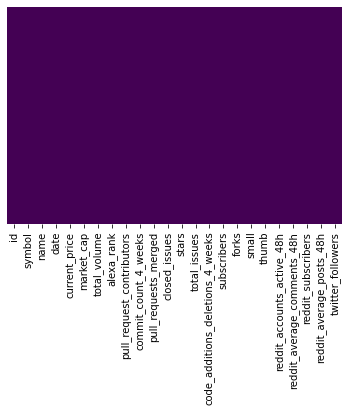

In [18]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

For numeric features, we want to know the range of values present and how often these values (or groups of values) occur.

For categorical features, we want to know the number of unique classes and how frequently they occur.

In [19]:
print(f"{m_}Average current_price: {df[~df.current_price.isnull()].current_price.mean():.1f}")


Average current_price: 16599.9


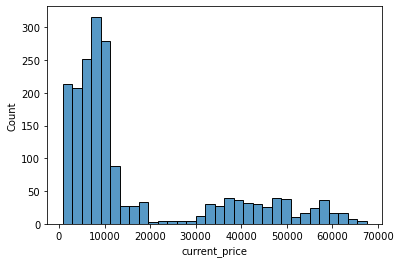

In [25]:
sns.histplot(x='current_price', data=df);

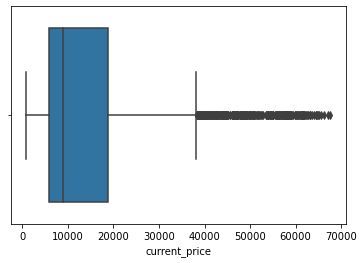

In [26]:
sns.boxplot(x=df['current_price']);

In the box plot, we can see that the right whisker has a near 40,000 current_price value.

We can see the positions of outlier

In [28]:
print(f"{m_}Average market_cap: {df[~df.market_cap.isnull()].market_cap.mean():.1f}")

Average market_cap: 305772650195.5


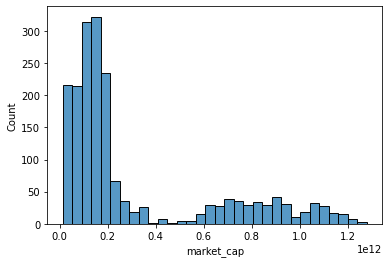

In [29]:
sns.histplot(x='market_cap', data=df);

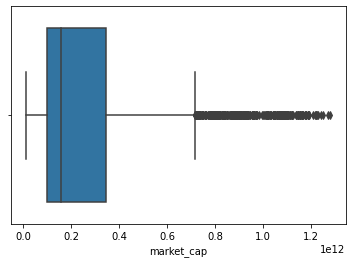

In [30]:
sns.boxplot(x=df['market_cap']);

In [31]:
print(f"{m_}Average total_volume: {df[~df.total_volume.isnull()].total_volume.mean():.1f}")

Average total_volume: 20587505254.9


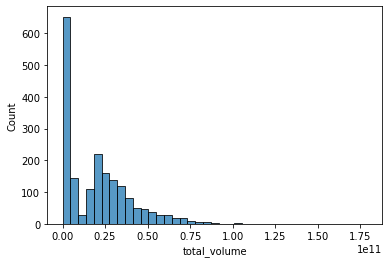

In [32]:
sns.histplot(x='total_volume', data=df);

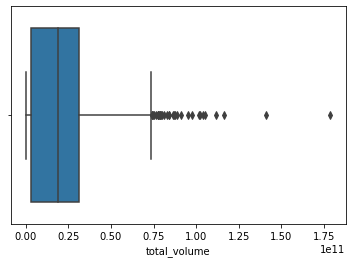

In [33]:
sns.boxplot(x=df['total_volume']);

In [34]:
print(f"{m_}Average alexa_rank: {df[~df.alexa_rank.isnull()].alexa_rank.mean():.1f}")

Average alexa_rank: 9722.0


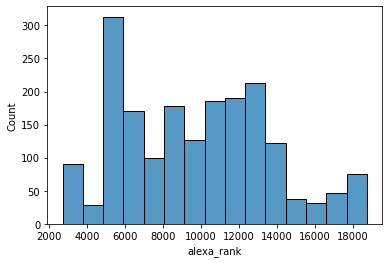

In [35]:
sns.histplot(x='alexa_rank', data=df);

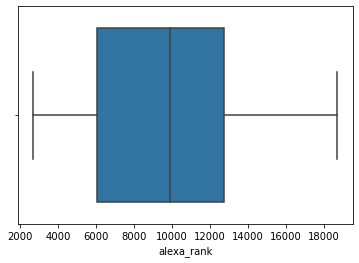

In [36]:
sns.boxplot(x=df['alexa_rank']);

In [37]:
print(f"{m_}Average pull_request_contributors: {df[~df.pull_request_contributors.isnull()].pull_request_contributors.mean():.1f}")

Average pull_request_contributors: 584.1


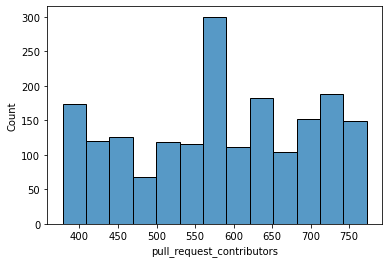

In [38]:
sns.histplot(x='pull_request_contributors', data=df);

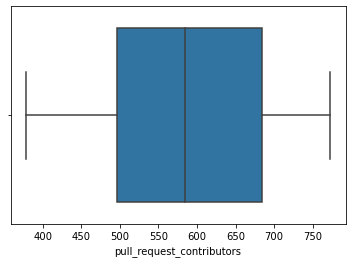

In [39]:
sns.boxplot(x=df['pull_request_contributors']);

In [40]:
print(f"{m_}Average commit_count_4_weeks: {df[~df.commit_count_4_weeks.isnull()].commit_count_4_weeks.mean():.1f}")

Average commit_count_4_weeks: 259.5


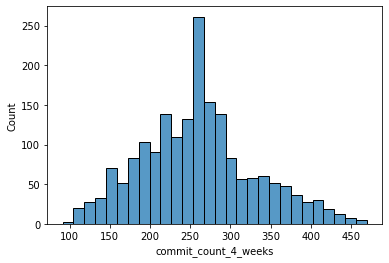

In [41]:
sns.histplot(x='commit_count_4_weeks', data=df);

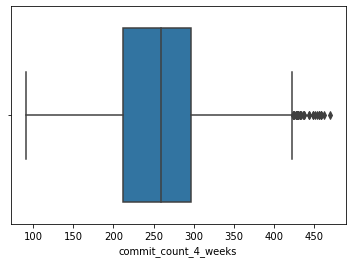

In [42]:
sns.boxplot(x=df['commit_count_4_weeks']);

In [43]:
print(f"{m_}Average pull_requests_merged: {df[~df.pull_requests_merged.isnull()].pull_requests_merged.mean():.1f}")

Average pull_requests_merged: 6645.3


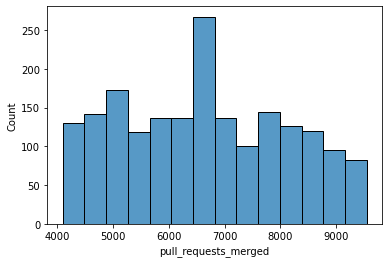

In [44]:
sns.histplot(x='pull_requests_merged', data=df);

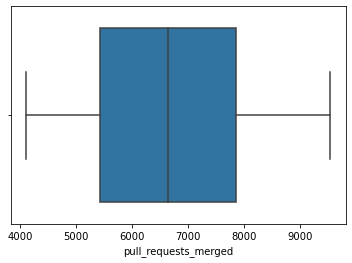

In [46]:
sns.boxplot(x=df['pull_requests_merged']);

In [47]:
print(f"{m_}Average clossed_issues: {df[~df.closed_issues.isnull()].closed_issues.mean():.1f}")

Average clossed_issues: 3524.3


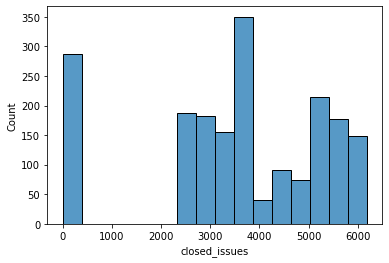

In [48]:
sns.histplot(x='closed_issues', data=df);

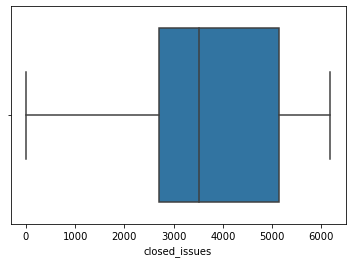

In [49]:
sns.boxplot(x=df['closed_issues']);

### Plots the histogram for each numerical feature in a separate subplot


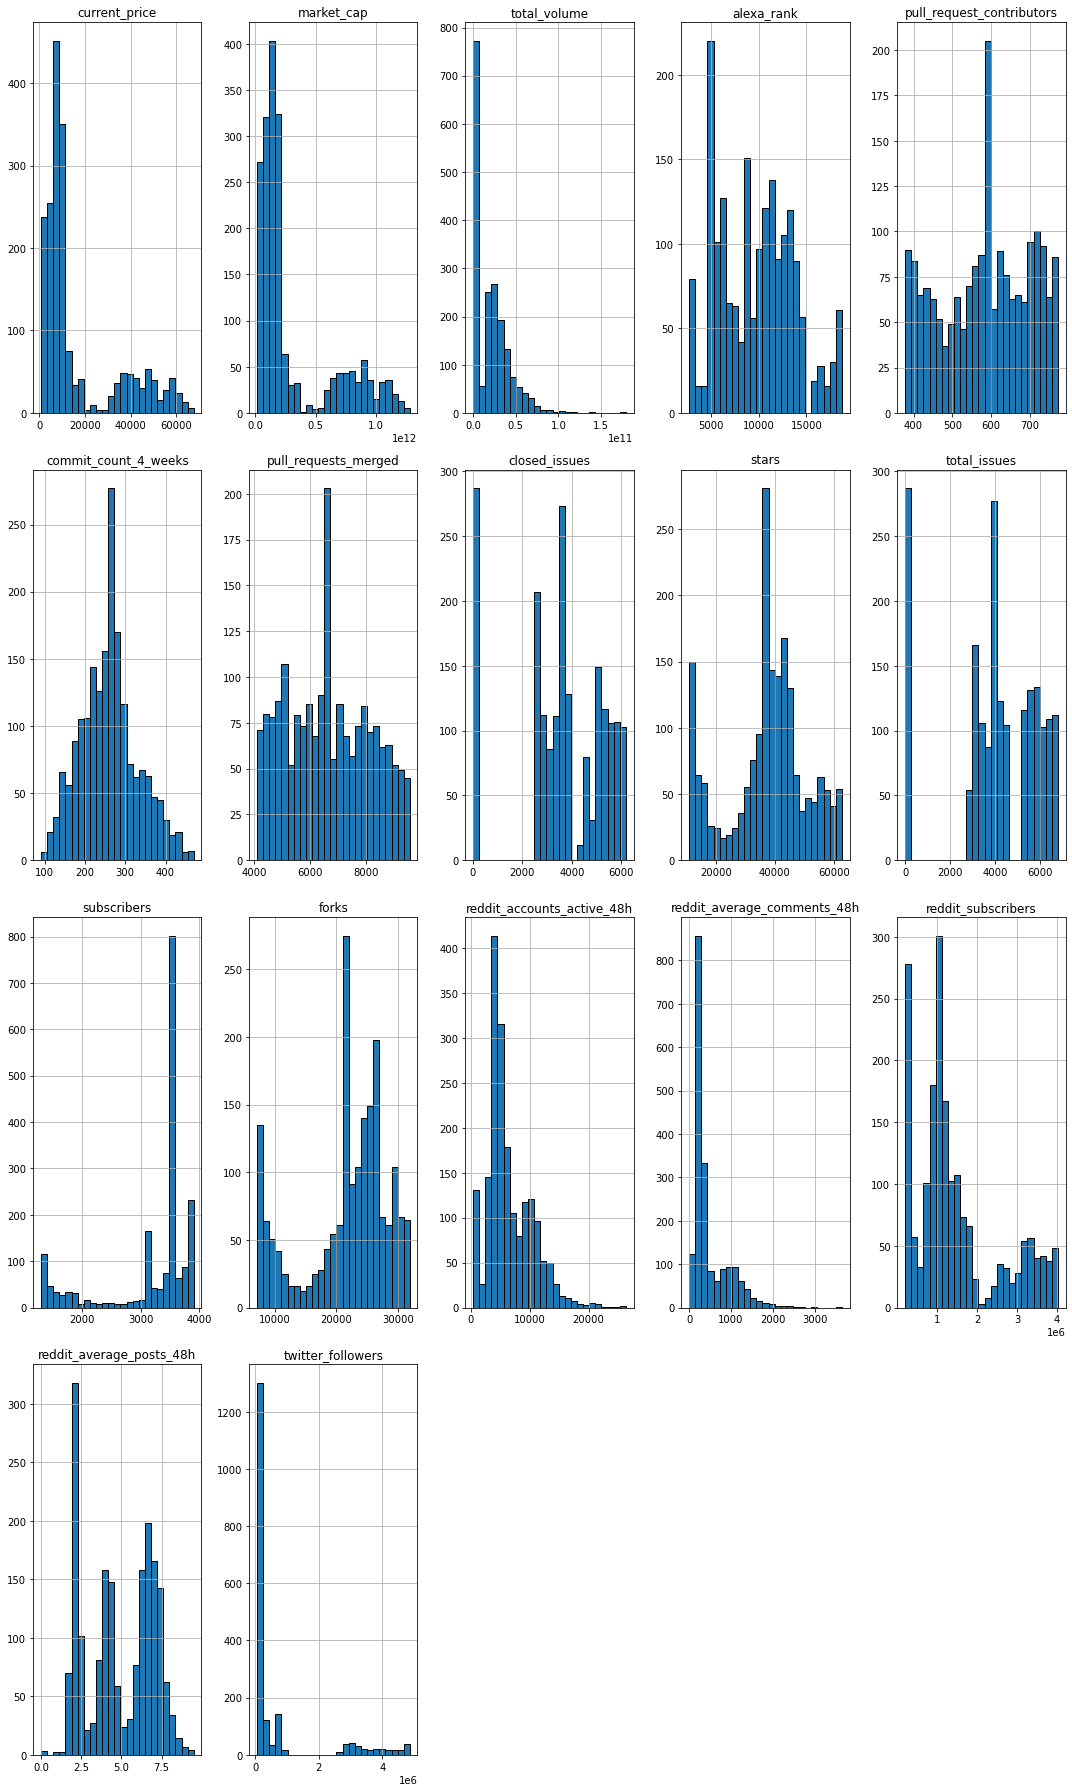

In [50]:
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout()

Correlation analysis measures the statistical relationship between two different variables. The result will show how the change in one parameter would impact the other parameter.

### Feature correlation.


Spearman correlation evaluates the monotonic relationship based on the ranked values for each feature .

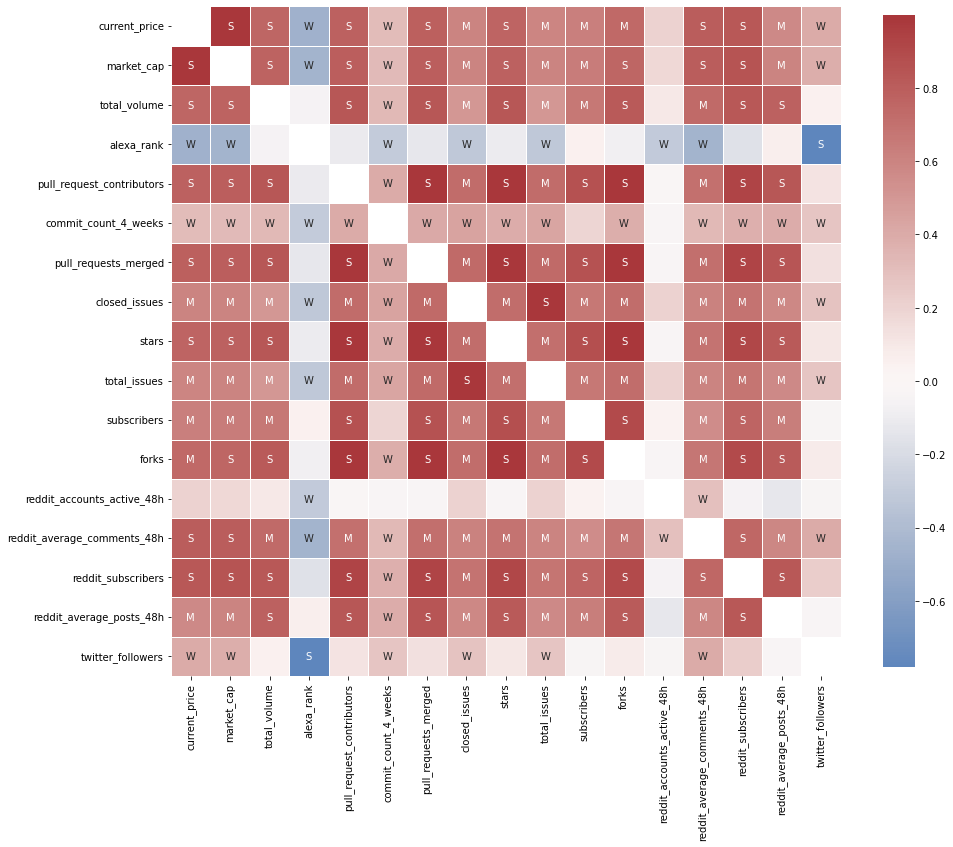

In [51]:
df_corr = df.corr(method="spearman")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});

### 3 experiments (or iterations) 

In [70]:
from varclushi import VarClusHi

In [71]:
import pickle
with open('X_v1.pkl', 'rb') as f:
    X = pickle.load(f)

with open('Y_v1.pkl', 'rb') as f:
    Y = pickle.load(f)

In [72]:
um=['symbol','ancla']

tad = X.merge(Y,on=um,how='left')
varc = sorted(tad.filter(like='x_').columns)
vart = ['tgt']

In [73]:
import pandas as pd
completitud=pd.DataFrame((1-tad.isnull().sum()/tad.shape[0])*100).reset_index().rename(columns={"index":"columna",0:"completitud"})
missings=pd.DataFrame(tad.isnull().sum()).reset_index().rename(columns={"index":"columna",0:"missings"})
completitud=completitud.merge(missings,how="inner",on="columna")
tipo=pd.DataFrame(tad.dtypes).reset_index().rename(columns={"index":"columna",0:"type"})
completitud=completitud.merge(tipo,how="inner",on="columna")
completitud

,columna,completitud,missings,type
0,symbol,100.0,0,object
1,ancla,100.0,0,int64
2,x_current_price_mean_15,100.0,0,float64
3,x_current_price_std_15,100.0,0,float64
4,x_market_cap_mean_15,100.0,0,float64
5,x_market_cap_std_15,100.0,0,float64
6,x_total_volume_mean_15,100.0,0,float64
7,x_total_volume_std_15,100.0,0,float64
8,x_current_price_mean_30,100.0,0,float64
9,x_current_price_std_30,100.0,0,float64


In [74]:
!gsutil cp gs://crispy-bucket-2022/models/utils/transform.py transform.py

Copying gs://crispy-bucket-2022/models/utils/transform.py...
/ [1 files][  3.4 KiB/  3.4 KiB]                                                
Operation completed over 1 objects/3.4 KiB.                                      


In [75]:
vc = VarClusHi(df=X,feat_list=varc)
vc.varclus()
rs = vc.rsquare
rs = rs.sort_values(by=['Cluster','RS_Ratio']).reset_index(drop=True)
rs['id'] = rs.groupby('Cluster').cumcount()+1
best = rs.loc[rs['id']==1]['Variable'].tolist()
best

['x_market_cap_std_60',
 'x_current_price_mean_45',
 'x_total_volume_mean_30',
 'x_current_price_std_30',
 'x_total_volume_std_60',
 'x_market_cap_std_15']

In [76]:
from transform import scaler_split

sp=scaler_split(df=tad,X=best,Y=vart)
sp.split(val=0.1,test=0.1,rs=220327)
sc = sp.scaler('MinMaxScaler')

with open('scaler_v1.pkl', 'wb') as f:
    pickle.dump(sc,f)

In [77]:
df = pd.concat([Y, X], axis=1)

In [78]:
df.dtypes

symbol                      object
ancla                        int64
tgt                          int64
symbol                      object
ancla                        int64
x_current_price_mean_15    float64
x_current_price_std_15     float64
x_market_cap_mean_15       float64
x_market_cap_std_15        float64
x_total_volume_mean_15     float64
x_total_volume_std_15      float64
x_current_price_mean_30    float64
x_current_price_std_30     float64
x_market_cap_mean_30       float64
x_market_cap_std_30        float64
x_total_volume_mean_30     float64
x_total_volume_std_30      float64
x_current_price_mean_45    float64
x_current_price_std_45     float64
x_market_cap_mean_45       float64
x_market_cap_std_45        float64
x_total_volume_mean_45     float64
x_total_volume_std_45      float64
x_current_price_mean_60    float64
x_current_price_std_60     float64
x_market_cap_mean_60       float64
x_market_cap_std_60        float64
x_total_volume_mean_60     float64
x_total_volume_std_6

In [113]:
data_features = df.drop(columns="tgt")
data_features = df.drop(columns="symbol")

In [80]:
data_label = df.tgt

In [81]:
data_label = data_label.replace("sube",1).replace("baja",0)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size=0.33, random_state=42)

In [83]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (255, 27)
Training Labels Shape: (255,)
Testing Features Shape: (127, 27)
Testing Labels Shape: (127,)


In [84]:
X_train.columns

Index(['ancla', 'tgt', 'ancla', 'x_current_price_mean_15',
       'x_current_price_std_15', 'x_market_cap_mean_15', 'x_market_cap_std_15',
       'x_total_volume_mean_15', 'x_total_volume_std_15',
       'x_current_price_mean_30', 'x_current_price_std_30',
       'x_market_cap_mean_30', 'x_market_cap_std_30', 'x_total_volume_mean_30',
       'x_total_volume_std_30', 'x_current_price_mean_45',
       'x_current_price_std_45', 'x_market_cap_mean_45', 'x_market_cap_std_45',
       'x_total_volume_mean_45', 'x_total_volume_std_45',
       'x_current_price_mean_60', 'x_current_price_std_60',
       'x_market_cap_mean_60', 'x_market_cap_std_60', 'x_total_volume_mean_60',
       'x_total_volume_std_60'],
      dtype='object')

### Random Forest Classifier

In [114]:
classifier = RandomForestClassifier(bootstrap=True, oob_score=True, random_state=1234)

hyper_param_grid = {'n_estimators': [100, 300],
                    'max_depth': [1, 10, 15],
                    'min_samples_split': [2, 5]}
# Using grid search!
gs = GridSearchCV(classifier,
                  hyper_param_grid,
                  scoring='precision',
                  cv=2
                 )
# RF

gs.fit(X_train, y_train)
print("Best parameters: " + str(gs.best_params_))
best_e = gs.best_estimator_
print("Best estimator: " + str(best_e))
print("Accuracy: " + str(gs.best_estimator_.oob_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best estimator: RandomForestClassifier(max_depth=10, oob_score=True, random_state=1234)
Accuracy: 0.9882352941176471


### Logistic Regression

In [86]:
data_label = df.tgt
data_label = data_label.replace("sube",1).replace("baja",0)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(data_features, data_label, test_size=0.33, random_state=42)
print(f"{len(X_train)} training samples")
print(f"{len(y_test)} test samples")

255 training samples
127 test samples


In [105]:
log_reg = sklearn.linear_model.LogisticRegression(C=1, penalty='elasticnet', solver='saga', l1_ratio=0.9,random_state=27,max_iter=1000000) #creating the model
log_reg.fit(X_train, y_train) #fiting the data to the model

LogisticRegression(C=1, l1_ratio=0.9, max_iter=1000000, penalty='elasticnet',
                   random_state=27, solver='saga')

In [106]:
score = log_reg.score(X_test, y_test)
print(score)

0.7559055118110236


### Neural Network

In [90]:
from transform import scaler_split

sp=scaler_split(df=tad,X=best,Y=vart)
sp.split(val=0.1,test=0.1,rs=220327)
sc = sp.scaler('MinMaxScaler')

with open('scaler_v1.pkl', 'wb') as f:
    pickle.dump(sc,f)

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoints = ModelCheckpoint("model_v1.h5",monitor='val_loss',verbose=10,save_best_only=True,
                              save_weights_only=False,mode="min",save_freq='epoch')

DNN = Sequential()
DNN.add(InputLayer(input_shape=sp.X_train.shape[1]))
DNN.add(Dense(2048, activation='relu'))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(1024, activation='relu',kernel_regularizer = l1_l2(0.001, 0.001)))
DNN.add(Dropout(rate=0.2))
DNN.add(Dense(256, activation='LeakyReLU'))
DNN.add(BatchNormalization())
DNN.add(Dense(64, activation='relu'))
DNN.add(Dense(16, activation='LeakyReLU',kernel_regularizer = l1_l2(0.01, 0.01)))
DNN.add(Dense(units=sp.Y_train.shape[1], activation='sigmoid'))
DNN.compile(optimizer=Adam(0.0001), loss= BinaryCrossentropy(),metrics=['accuracy','AUC'])
DNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              14336     
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

2022-04-09 01:57:49.117485: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [94]:
DNN.fit(x=sp.X_train, y=sp.Y_train, batch_size=16, epochs=300, validation_data=(sp.X_val, sp.Y_val),callbacks=[checkpoints])

### Results

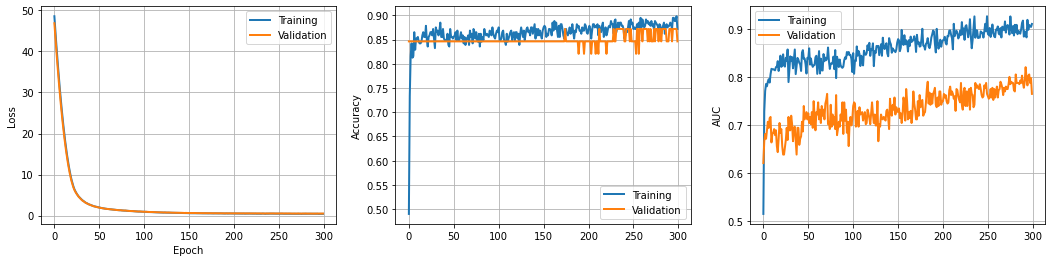

In [93]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.plot(DNN.history.history['loss'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_loss'], label='Validation', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(DNN.history.history['accuracy'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_accuracy'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(DNN.history.history['auc'], label='Training', linewidth=2)
plt.plot(DNN.history.history['val_auc'], label='Validation', linewidth=2)
plt.legend()
plt.ylabel('AUC')
plt.grid(True)

plt.show()